In [328]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml
from tqdm import tqdm
from PIL import Image

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torch import autograd
from torch.autograd import Variable
from opt_einsum import contract

from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [329]:
num_qubits = 3
q_depth = 2
num_ancilla = 1
time_qubits = 1
time_steps = 5

In [330]:
class MNIST(Dataset):
    def __init__(self, path, img_size, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv(path)
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)
        self.labels = fashion_df.label.values
        print('Image size:', self.images.shape)
        print('--- Label ---')
        print(fashion_df.label.value_counts())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.images[idx]
        img = Image.fromarray(self.images[idx])
            
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [331]:
batch_size = 1
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), transforms.Resize(8)])
dataset = MNIST('mnist_train.csv', 8, transform = transform)

Image size: (735000, 8, 8)
--- Label ---
label
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64


In [332]:
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False
)

In [333]:
new_loader = []
counter = 0
for (data,label) in train_loader:
    if label == 0:
        new_loader.append((data, label))
        counter+=1
    if counter == 200:
        break

In [334]:
# Quantum simulator
forward_dev = qml.device("default.mixed", wires=num_qubits+time_qubits)
backward_dev = qml.device("lightning.qubit", wires=num_qubits+time_qubits)
gan_dev = qml.device("lightning.qubit", wires=num_qubits+time_qubits+5)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [335]:
def kraus_ops(n, p):
    '''outputs the kraus operators for an N qubit depolarizing channel'''
    kraus_ops = []
    for i in range(2**n):
        v= np.zeros(2**n)
        v[i] = 1
        for j in range(2**n):
            w = np.zeros(2**n)
            w[j] = 1
            kraus_ops.append(np.sqrt(p/2**n) * np.outer(v,w))
    kraus_ops.append(np.sqrt(1-p) * np.eye(2**n))
    return kraus_ops


In [336]:
ops = kraus_ops(3, 0.112323)
K_arr = np.array(ops)
Kraus_sum = np.einsum("ajk,ajl->kl", K_arr.conj(), K_arr)
print(Kraus_sum)
print(np.allclose(Kraus_sum, np.eye(ops[0].shape[0])))

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
True


In [337]:
@qml.qnode(backward_dev)
def initial_state(params):
    for i in range(num_qubits):
        qml.Rot(params[3*i], params[3*i+1], params[3*i+2], wires = i)
    # for i in range(num_qubits-1):
    #     qml.ctrl(qml.U2(params[9+2*i], params[9+2*i+1], wires = i+1), 
    #              control = i, control_values = (1))
    # qml.Barrier()
    for i in range(num_qubits):
        qml.U2(params[9+2*i], params[9+2*i+1], wires = i)
        if i != num_qubits - 1:
            qml.CNOT(wires = [i,i+1])
    # qml.Barrier()
    qml.MultiRZ(params[15], wires = list(range(num_qubits)))
    # for i in range(num_qubits):
    #     qml.Rot(params[19+3*i], params[19+3*i+1], params[19+3*i+2], wires = i)
    #     if i != num_qubits - 1:
    #         qml.CNOT(wires = [i,i+1])
    qml.Barrier()
        

    return qml.density_matrix(wires = list(range(num_qubits)))

params = np.arange(16)
print(qml.draw(initial_state)(params))

    
    
    
    

0: ──Rot(0.00,1.00,2.00)──U2(9.00,10.00)─╭●──────────────────────────────────────╭MultiRZ(15.00)──||─┤
1: ──Rot(3.00,4.00,5.00)─────────────────╰X──U2(11.00,12.00)─╭●──────────────────├MultiRZ(15.00)──||─┤
2: ──Rot(6.00,7.00,8.00)─────────────────────────────────────╰X──U2(13.00,14.00)─╰MultiRZ(15.00)──||─┤

  ╭State
  ├State
  ╰State


In [338]:
@qml.qnode(forward_dev)
def scrambled_state_t(time, input):
    # print('starting')
    # input = [input[i][i]/np.sqrt(np.trace(np.absolute(input))) for i in range(2**num_qubits)]
    # input = np.sqrt(np.absolute(input))
    qml.QubitDensityMatrix(input, wires = list(range(num_qubits)))    
        
    alpha = time/(time_steps - 1)
    ops = kraus_ops(num_qubits, alpha)
    qml.QubitChannel(K_list=ops, wires = list(range(num_qubits)), id = f'Depolarizing({alpha})')

    return qml.density_matrix(wires = list(range(num_qubits)))

In [339]:
class ForwardDiffusion(nn.Module):
    def __init__(self, num_qubits, time_steps, num_generators = 4):
        super().__init__()

        self.num_qubits = num_qubits
        self.time_steps = time_steps
        self.num_generators = num_generators

    def diffusion_data_t(self, time, inputs):
        data = torch.zeros((self.num_generators, 2**self.num_qubits, 2**self.num_qubits)).cfloat()
        # print(data.shape)
        for i, image in enumerate(inputs):
            #Get mixed state and turn into a pure state
            # print(image)
            state = scrambled_state_t(time, image)
            # state = [state[i][i]/np.sqrt(np.trace(np.absolute(state))) for i in range(2**num_qubits)]
            # state = np.sqrt(np.absolute(state))
            data[i] = state
        return data





(<Figure size 900x500 with 1 Axes>, <Axes: >)

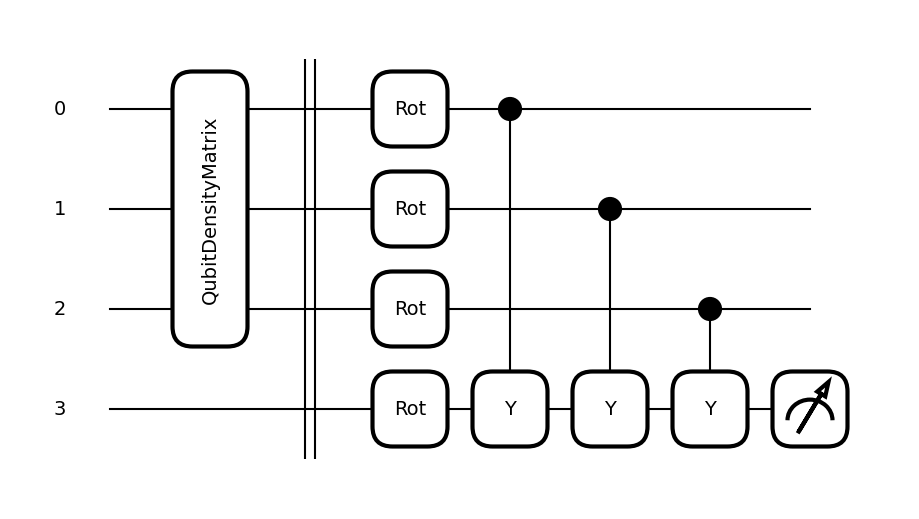

In [340]:
@qml.qnode(forward_dev, diff_method='best')
def quantum_circuit(input_state, params, depth):
    qml.QubitDensityMatrix(input_state, wires = list(range(num_qubits)))
    qml.Barrier()
    const = 12
    for i in range(depth):
        for j in range(num_qubits+time_qubits):
            qml.Rot(params[const*i + 3*j], 
                    params[const*i + 3*j+1], 
                    params[const*i + 3*j+2], wires=j)
        for j in range(num_qubits):
            qml.CY(wires = [j, 3])
        # qml.CNOT([0,3])
        # qml.CRZ(params[const*i + 9*(num_qubits+time_qubits)+2], wires = [0,1])
        # qml.CRZ(params[const*i + 9*(num_qubits+time_qubits)+3],wires = [1,2])
        # qml.CRZ(params[const*i + 9*(num_qubits+time_qubits)+4],wires = [2,3])
        # qml.IsingXY(params[const*i + 3*(num_qubits+time_qubits)], wires = [1,2])
        # qml.IsingXY(params[const*i + 3*(num_qubits+time_qubits)+1], wires = [0,3])
        # qml.Barrier()
        # for j in range(num_qubits+time_qubits):
        #     qml.Rot(params[const*i + 3*(num_qubits+time_qubits)+2+3*j], 
        #             params[const*i + 3*(num_qubits+time_qubits)+2+3*j+1], 
        #             params[const*i + 3*(num_qubits+time_qubits)+2+3*j+2], wires=j)
        # qml.SWAP(wires = [0,2])
        # qml.CRZ(params[const*i + 9*(num_qubits+time_qubits)+5],wires = [3,2])
        # # qml.SWAP(wires = [1,3])
        # qml.CRZ(params[const*i + 9*(num_qubits+time_qubits)+6],wires = [2,1])
        # qml.CRZ(params[const*i + 9*(num_qubits+time_qubits)+7],wires = [1,0])
        # for j in range(num_qubits+time_qubits):
        #     qml.Rot(params[const*i + 6*(num_qubits+time_qubits)+2+3*j], 
        #             params[const*i + 6*(num_qubits+time_qubits)+2+3*j+1], 
        #             params[const*i + 6*(num_qubits+time_qubits)+2+3*j+2], wires=j)

    return qml.density_matrix(wires = 3)

@qml.qnode(forward_dev, diff_method='best')
def time_circuit(time_embed, params):
    const = 5
    for i in range(2):
        for j in range(num_qubits):
            qml.Rot(time_embed, time_embed, time_embed, wires = j)
            qml.CNOT(wires = [j, (j+1) % num_qubits])
        qml.MultiRZ(params[const*i], wires = list(range(num_qubits)))
        qml.IsingXY(params[const*i + 1], wires = [0,2])
        for j in range(num_qubits):
            qml.RY(params[const*i + 2 + j], wires = j)
        qml.CZ(wires = [1,0])
        qml.CZ(wires = [1,2])
    return qml.density_matrix(wires = [0,1,2])

@qml.qnode(forward_dev, diff_method='best')
def final_circuit(time_state, quantum_state, params):
    const = 12
    qml.QubitDensityMatrix(time_state, wires = [0,1,2])
    qml.QubitDensityMatrix(quantum_state, wires = 3)
    for i in range(2):
        for j in range(num_qubits+time_qubits):
            qml.Rot(params[const*i + 3*j], 
                    params[const*i + 3*j+1], 
                    params[const*i + 3*j+2], wires=j)
        for j in range(num_qubits):
            qml.Hadamard(3)
            qml.RX(params[const*i + 12 + 2*j], wires = 3)
            qml.IsingZZ(params[const*i + 12 + 2*j + 1], wires = [j, 3])
            qml.CNOT(wires = [3, j])
        qml.IsingYY(params[const*(i+1) - 1], wires = [0,1])
    return qml.density_matrix(wires = [0,1,2])
        
       
        


weights = np.arange(44)
qml.draw_mpl(quantum_circuit)(np.zeros(shape = (8,8)), weights, 1)


In [362]:

class QDDPM(nn.Module):
    def __init__(self, num_qubits, time_steps, q_depth, num_generators = 4):
        super().__init__()

        self.num_qubits = num_qubits
        self.time_steps = time_steps
        self.num_generators = num_generators
        self.q_depth = q_depth
        # self.expand = nn.Sequential(
        #     nn.ConvTranspose2d(32,1,25,1),
        #     # nn.LeakyReLU(),
        #     # nn.ConvTranspose2d(32,1,16,2),
        #     nn.Sigmoid()
        # )
    
    def set_diffusionSet(self, diffused_states):
        self.diffused_states = diffused_states
    
    def backward_output_t(self, inputs, q_params, t):
        # probs = torch.Tensor()
        # probs.requires_grad = True
        # for i in range(2**self.num_qubits):
        #     probs = torch.cat((probs, quantum_circuit(inputs,params)[i][i]))
        # probs = torch.div(probs, torch.sqrt(torch.sum(probs)))
        outputs_t = torch.zeros((self.num_generators, 2**self.num_qubits,  2**self.num_qubits)).cfloat()
        # print(outputs_t.shape)
        # print(len(self.q_params))
        for i in range(len(inputs)):
            # print(inputs[0][i].shape)
            quantum_output = quantum_circuit(inputs[i],q_params[i][:24], self.q_depth)
            time= t * np.pi / self.time_steps
            time_output = time_circuit(time, q_params[i][24:34])
            outputs_t[i] = torch.Tensor(final_circuit(time_output, quantum_output, q_params[i][34:])).cfloat()

        return outputs_t
    
    def prepareInput_t(self, inputs, t, q_params):
        '''t: time step that we are preparing the input for. 0<=t<= self.time_steps-1'''
        if t == self.time_steps-1:
            self.input_tplus1 = torch.zeros(size = (self.time_steps, 
                                         len(new_loader), 
                                         self.num_generators, 
                                         2**(self.num_qubits), 
                                         2**(self.num_qubits))).cfloat()
            self.input_tplus1[t] = torch.from_numpy(inputs)
        if t < self.time_steps - 1:
            for i in range(len(new_loader)):
                self.input_tplus1[t, i] = self.backward_output_t(self.input_tplus1[t+1, i], q_params[t+1], t)
        return self.input_tplus1[t]
    
    def backDataGeneration(self, inputs, q_params):
        states = torch.zeros((self.time_steps+1,len(new_loader), self.num_generators,2**self.num_qubits,2**self.num_qubits)).cfloat()
        states[-1, :, :, :2**self.num_qubits, :2**self.num_qubits] = torch.tensor(inputs)
        with torch.no_grad():
            for tt in tqdm(range(self.time_steps-1, -1, -1)):
                for i in range(len(states[0])):
                    states[tt,i,:, :,:] = self.backward_output_t(states[tt+1,i,:,:,:], q_params[tt], tt)
        return states
    

In [342]:
def naturalDistance(Set1, Set2):
    '''
        a natural measure on the distance between two sets of quantum states
        definition: 2*d - r1-r2
        d: mean of inter-distance between Set1 and Set2
        r1/r2: mean of intra-distance within Set1/Set2
    '''
    # a natural measure on the distance between two sets, according to trace distance
    r11 = 1. - torch.mean(torch.abs(contract('mi,ni->mn', Set1.conj(), Set1))**2)
    r22 = 1. - torch.mean(torch.abs(contract('mi,ni->mn', Set2.conj(), Set2))**2)
    r12 = 1. - torch.mean(torch.abs(contract('mi,ni->mn', Set1.conj(), Set2))**2)
    return 2*r12 - r11 - r22

In [343]:
diffusion_loader = []

In [344]:
for i, (data,_) in enumerate(new_loader):
    diffusion_loader.append((data.view(4,16), _))

In [345]:
forward_model = ForwardDiffusion(num_qubits, time_steps)
diffused_states = torch.zeros((time_steps, len(new_loader), 4, 2**num_qubits, 2**num_qubits)).cfloat()
input_states = torch.zeros((len(new_loader), 4, 2**num_qubits, 2**num_qubits)).cfloat()
for t in tqdm(range(time_steps)):
    for i, (image,_ ) in enumerate(diffusion_loader):
        for j in range(len(image)):
            # initial_state(image[j])
            # print(image.shape)
            input_states[i, j,:,:] = initial_state(image[j])
            # print(input_states[i,j])
        # print(input_states[i,:,:,:])
        # print(input_states[i,:,:,:].shape)
        diffused_states[t, i,:,:,:] = forward_model.diffusion_data_t(t, input_states[i,:,:,:])

# diffused_states


100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


In [346]:
np.save('diffused_states', diffused_states)

In [347]:
diffused_states = np.load('diffused_states.npy')

In [348]:
diffused_states.shape

(5, 200, 4, 8, 8)

In [349]:
def compute_fidelity(Xout, Xin):
    '''
    Given Xout of shape [T+1, Ndata, 2**n], compute the fidelity between times t = t and t = 0 as a function of T averaged over the batch 
    '''
    arr = np.zeros(time_steps)
    for i in range(time_steps):
        initial_rho = Xout[0][0][1]
        diffused_rho = Xin[i][0][1]
        arr[i] = qml.math.fidelity(torch.from_numpy(initial_rho), diffused_rho)
    return arr

Text(0.5, 1.0, 'Fidelity across diffusion')

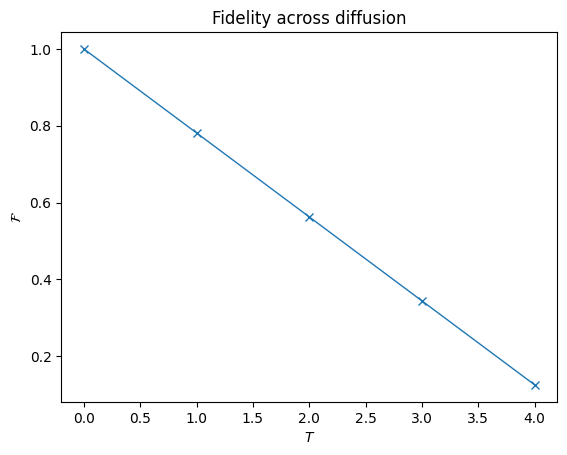

In [350]:
arr = compute_fidelity(diffused_states,diffused_states)
plt.plot(arr,marker = 'x',linewidth=1)
plt.xlabel(r'$T$')
plt.ylabel(r'$\mathcal{F}$')
plt.title('Fidelity across diffusion')

In [351]:
def trace_distance(rho, sigma):
    return (0.5)*torch.sum(torch.abs(torch.linalg.eigvals(rho-sigma)))

In [456]:
import time

def Training_t(model, t, inputs_T, params_tot):
    '''
    the trianing for the backward PQC at step t
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    inputs_T: the input data at step t=T
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    '''
     # prepare input
    states_diff = model.diffused_states
    loss_hist = [] # record of training history

    # initialize parameters

    # set optimizer and learning rate decay
    params_t = torch.Tensor()
    if t == model.time_steps - 1:
        params_t = torch.rand(size = (4, 58*model.q_depth))
    else:
        params_t = torch.Tensor(params_tot[t+1])
    params_t.requires_grad = True
    input_tplus1 = model.prepareInput_t(inputs_T, t, params_tot)
    # print(input_tplus1)
    optimizer = torch.optim.Adam([params_t], lr=0.001)
    
    t0 = time.time()
    for epoch in range(3):
        for step in range(len(new_loader)):
            # print(params_t)
            loss = torch.Tensor([0])
            
            true_data = states_diff[t, step]

            output_t = model.backward_output_t(input_tplus1[step], params_t, t)
            for i in range(4):
                loss += 1 - qml.math.fidelity(torch.abs(output_t[i]).float(), torch.from_numpy(np.absolute(true_data[i])).float())

                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_hist.append(loss.item()) # record the current loss
            
            if (step)%20 == 0:
                loss_value = loss_hist[-1]
                print(f"Epoch {epoch+1}, Step {step}, loss: {loss_value:0.9f}, time elapsed: {time.time()-t0} seconds")

    return params_t, loss_hist

In [457]:
model = QDDPM(num_qubits=num_qubits, time_steps=time_steps-1, q_depth=q_depth)
model.set_diffusionSet(np.copy(diffused_states))

inputs_T = np.copy(diffused_states[-1])
model.input_tplus1 = inputs_T

In [458]:
params_tot = np.zeros((model.time_steps, 4, 58*q_depth))
loss_tot = np.zeros((model.time_steps, 3*len(new_loader)))

In [459]:
# denoise training layer of backward PQC

# generate random samples at step t=T


# load diffusion process


for t in tqdm(range(model.time_steps-1, -1, -1)):
    params, loss_hist = Training_t(model, t, inputs_T, params_tot) #train the PQC at t, store the results in params_tot, and then 
    params_tot[t] = (params).detach().numpy()                                     # train at t - 1, and so on
    loss_tot[t] = loss_hist

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1, Step 0, loss: 1.134288311, time elapsed: 0.3561077117919922 seconds
Epoch 1, Step 20, loss: 1.150920868, time elapsed: 7.360278844833374 seconds
Epoch 1, Step 40, loss: 1.098224521, time elapsed: 13.72658896446228 seconds
Epoch 1, Step 60, loss: 1.134847879, time elapsed: 20.190710067749023 seconds
Epoch 1, Step 80, loss: 1.090679884, time elapsed: 26.768855810165405 seconds
Epoch 1, Step 100, loss: 1.069550633, time elapsed: 32.930436849594116 seconds
Epoch 1, Step 120, loss: 1.069509149, time elapsed: 39.23735690116882 seconds
Epoch 1, Step 140, loss: 1.081018567, time elapsed: 45.38478994369507 seconds
Epoch 1, Step 160, loss: 1.122349858, time elapsed: 51.513705015182495 seconds
Epoch 1, Step 180, loss: 1.176150322, time elapsed: 58.130499839782715 seconds
Epoch 2, Step 0, loss: 1.069460869, time elapsed: 64.71475791931152 seconds
Epoch 2, Step 20, loss: 1.064390063, time elapsed: 71.53535890579224 seconds
Epoch 2, Step 40, loss: 1.069434404, time elapsed: 78.1359097957611

 25%|██▌       | 1/4 [03:15<09:45, 195.13s/it]

Epoch 1, Step 0, loss: 0.795419455, time elapsed: 0.2862229347229004 seconds
Epoch 1, Step 20, loss: 0.889778376, time elapsed: 7.085310935974121 seconds
Epoch 1, Step 40, loss: 0.832761168, time elapsed: 13.602755784988403 seconds
Epoch 1, Step 60, loss: 0.952925682, time elapsed: 21.07041907310486 seconds
Epoch 1, Step 80, loss: 0.871619344, time elapsed: 27.26883292198181 seconds
Epoch 1, Step 100, loss: 0.783699691, time elapsed: 33.56075382232666 seconds
Epoch 1, Step 120, loss: 0.783617496, time elapsed: 40.55760216712952 seconds
Epoch 1, Step 140, loss: 0.903076768, time elapsed: 46.61144304275513 seconds
Epoch 1, Step 160, loss: 0.795100927, time elapsed: 52.51803183555603 seconds
Epoch 1, Step 180, loss: 1.044589520, time elapsed: 58.790497064590454 seconds
Epoch 2, Step 0, loss: 0.783580482, time elapsed: 64.91307401657104 seconds
Epoch 2, Step 20, loss: 0.822364211, time elapsed: 71.48438501358032 seconds
Epoch 2, Step 40, loss: 0.783567548, time elapsed: 78.37657880783081 s

 50%|█████     | 2/4 [06:55<06:59, 209.99s/it]

Epoch 1, Step 0, loss: 0.774981499, time elapsed: 0.2831690311431885 seconds
Epoch 1, Step 20, loss: 0.789858103, time elapsed: 6.454640865325928 seconds
Epoch 1, Step 40, loss: 0.745870054, time elapsed: 12.585620880126953 seconds
Epoch 1, Step 60, loss: 0.997249603, time elapsed: 19.166942834854126 seconds
Epoch 1, Step 80, loss: 0.821319640, time elapsed: 25.322964906692505 seconds
Epoch 1, Step 100, loss: 0.738980055, time elapsed: 31.67195177078247 seconds
Epoch 1, Step 120, loss: 0.738965034, time elapsed: 38.21100997924805 seconds
Epoch 1, Step 140, loss: 0.872417212, time elapsed: 44.48038983345032 seconds
Epoch 1, Step 160, loss: 0.872867882, time elapsed: 50.8930287361145 seconds
Epoch 1, Step 180, loss: 1.037744880, time elapsed: 58.17008876800537 seconds
Epoch 2, Step 0, loss: 0.738922417, time elapsed: 64.49481797218323 seconds
Epoch 2, Step 20, loss: 0.769276559, time elapsed: 70.65562105178833 seconds
Epoch 2, Step 40, loss: 0.738898635, time elapsed: 77.18547081947327 s

 75%|███████▌  | 3/4 [10:34<03:34, 214.21s/it]

Epoch 1, Step 0, loss: 1.843371749, time elapsed: 0.2841372489929199 seconds
Epoch 1, Step 20, loss: 1.811014175, time elapsed: 7.313305139541626 seconds
Epoch 1, Step 40, loss: 1.638831496, time elapsed: 13.527959108352661 seconds
Epoch 1, Step 60, loss: 1.729282618, time elapsed: 19.885071277618408 seconds
Epoch 1, Step 80, loss: 1.459576130, time elapsed: 26.005990266799927 seconds
Epoch 1, Step 100, loss: 1.210625887, time elapsed: 32.30150508880615 seconds
Epoch 1, Step 120, loss: 1.050739765, time elapsed: 38.58368730545044 seconds
Epoch 1, Step 140, loss: 1.023715258, time elapsed: 45.09444522857666 seconds
Epoch 1, Step 160, loss: 0.906208277, time elapsed: 51.395519971847534 seconds
Epoch 1, Step 180, loss: 1.081912875, time elapsed: 57.551239252090454 seconds
Epoch 2, Step 0, loss: 0.607656002, time elapsed: 63.71958518028259 seconds
Epoch 2, Step 20, loss: 0.584481478, time elapsed: 69.82501721382141 seconds
Epoch 2, Step 40, loss: 0.472794533, time elapsed: 76.0011262893676

100%|██████████| 4/4 [26:10<00:00, 392.71s/it]


In [407]:
np.save('diffusion_params', params_tot)

In [408]:
params_tot = np.load('diffusion_params.npy')

In [409]:
params_tot

array([[[ 0.84277368,  0.14257509,  0.99656731, ...,  0.92548132,
          0.79262209,  0.09988803],
        [ 0.77352655,  0.47980443,  0.75013685, ...,  0.32014322,
          0.74426365,  0.65602726],
        [ 0.06895739,  1.05314362, -0.09368863, ...,  0.11014134,
          0.88939637,  0.45220405],
        [ 0.56452888,  1.04308581,  0.45214587, ...,  0.12218648,
          0.49999428,  0.07559657]],

       [[ 0.89008462,  0.63048589,  0.80671364, ...,  0.92548132,
          0.79262209,  0.09988803],
        [ 0.36520803,  0.22522141,  0.32249907, ...,  0.32014322,
          0.74426365,  0.65602726],
        [ 0.42217517,  0.75061202,  0.05808668, ...,  0.11014134,
          0.88939637,  0.45220405],
        [ 0.92247355,  0.89341193,  0.52577412, ...,  0.12218648,
          0.49999428,  0.07559657]],

       [[ 0.9092108 ,  0.61105138,  0.82590449, ...,  0.92548132,
          0.79262209,  0.09988803],
        [ 0.37992004,  0.23994416,  0.3372089 , ...,  0.32014322,
          0.

In [410]:
input_tplus1 = model.prepareInput_t(inputs_T, model.time_steps-1, params_tot[0])
diffusion_generation = model.backDataGeneration(input_tplus1, params_tot)

/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_11908/854229653.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states[-1, :, :, :2**self.num_qubits, :2**self.num_qubits] = torch.tensor(inputs)
100%|██████████| 4/4 [01:47<00:00, 26.81s/it]


In [416]:
inputs_T

array([[[0.125+0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
         0.   +0.j, 0.   +0.j, 0.   +0.j],
        [0.   +0.j, 0.125+0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
         0.   +0.j, 0.   +0.j, 0.   +0.j],
        [0.   +0.j, 0.   +0.j, 0.125+0.j, 0.   +0.j, 0.   +0.j,
         0.   +0.j, 0.   +0.j, 0.   +0.j],
        [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.125+0.j, 0.   +0.j,
         0.   +0.j, 0.   +0.j, 0.   +0.j],
        [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.125+0.j,
         0.   +0.j, 0.   +0.j, 0.   +0.j],
        [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
         0.125+0.j, 0.   +0.j, 0.   +0.j],
        [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
         0.   +0.j, 0.125+0.j, 0.   +0.j],
        [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
         0.   +0.j, 0.   +0.j, 0.125+0.j]],

       [[0.125+0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
         0.   +0.j, 0.   +0.j, 0.   +0.j],
        [0.   +0.j, 0.125+0.j, 0.  

In [418]:
diffused_states[-1]

array([[[[0.125+0.j, 0.   +0.j, 0.   +0.j, ..., 0.   +0.j, 0.   +0.j,
          0.   +0.j],
         [0.   +0.j, 0.125+0.j, 0.   +0.j, ..., 0.   +0.j, 0.   +0.j,
          0.   +0.j],
         [0.   +0.j, 0.   +0.j, 0.125+0.j, ..., 0.   +0.j, 0.   +0.j,
          0.   +0.j],
         ...,
         [0.   +0.j, 0.   +0.j, 0.   +0.j, ..., 0.125+0.j, 0.   +0.j,
          0.   +0.j],
         [0.   +0.j, 0.   +0.j, 0.   +0.j, ..., 0.   +0.j, 0.125+0.j,
          0.   +0.j],
         [0.   +0.j, 0.   +0.j, 0.   +0.j, ..., 0.   +0.j, 0.   +0.j,
          0.125+0.j]],

        [[0.125+0.j, 0.   +0.j, 0.   +0.j, ..., 0.   +0.j, 0.   +0.j,
          0.   +0.j],
         [0.   +0.j, 0.125+0.j, 0.   +0.j, ..., 0.   +0.j, 0.   +0.j,
          0.   +0.j],
         [0.   +0.j, 0.   +0.j, 0.125+0.j, ..., 0.   +0.j, 0.   +0.j,
          0.   +0.j],
         ...,
         [0.   +0.j, 0.   +0.j, 0.   +0.j, ..., 0.125+0.j, 0.   +0.j,
          0.   +0.j],
         [0.   +0.j, 0.   +0.j, 0.   +0.j, ..., 0.

In [419]:
diffusion_generation[0]

tensor([[[[ 0.0923-5.2042e-18j, -0.0174-1.0522e-01j,  0.0984-1.3328e-02j,
            ..., -0.0906+7.7430e-02j,  0.1098-7.5732e-03j,
           -0.0277-9.3914e-02j],
          [-0.0174+1.0522e-01j,  0.1370-6.0715e-17j, -0.0032+1.2102e-01j,
            ..., -0.0716-1.1915e-01j, -0.0125+1.3208e-01j,
            0.1167-1.6100e-02j],
          [ 0.0984+1.3328e-02j, -0.0032-1.2102e-01j,  0.1130-1.1341e-16j,
            ..., -0.1066+7.1087e-02j,  0.1175+1.0001e-02j,
           -0.0193-1.0488e-01j],
          ...,
          [-0.0906-7.7430e-02j, -0.0716+1.1915e-01j, -0.1066-7.1087e-02j,
            ...,  0.1659-4.9656e-17j, -0.1162-8.8846e-02j,
           -0.0570+1.2097e-01j],
          [ 0.1098+7.5732e-03j, -0.0125-1.3208e-01j,  0.1175-1.0001e-02j,
            ..., -0.1162+8.8846e-02j,  0.1416-5.4644e-17j,
           -0.0249-1.1876e-01j],
          [-0.0277+9.3914e-02j,  0.1167+1.6100e-02j, -0.0193+1.0488e-01j,
            ..., -0.0570-1.2097e-01j, -0.0249+1.1876e-01j,
            0.1112-5.6

[0.26257948 0.03952328 0.04002689 0.03298132 0.12502412]


Text(0.5, 1.0, 'Fidelity across diffusion')

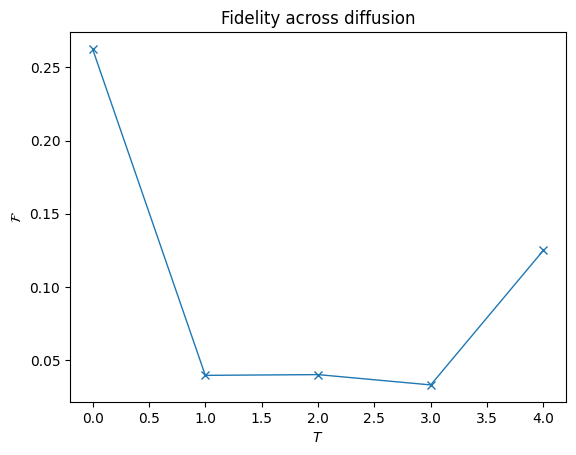

In [420]:
arr = compute_fidelity(diffused_states, diffusion_generation)
print(arr)
plt.plot(arr,marker = 'x',linewidth=1)
plt.xlabel(r'$T$')
plt.ylabel(r'$\mathcal{F}$')
plt.title('Fidelity across diffusion')

In [393]:
print(diffusion_generation[0][0][0])
print(diffusion_generation[1][0][0])

tensor([[ 0.1223-2.9490e-17j, -0.1148+3.4471e-02j, -0.0910-7.0664e-02j,
         -0.1095+6.3649e-02j, -0.0242+1.1576e-01j,  0.0937-6.4594e-02j,
          0.1162-2.8173e-02j, -0.0256+1.1916e-01j],
        [-0.1148-3.4471e-02j,  0.1239-3.2092e-17j,  0.0613+9.9256e-02j,
          0.1182-2.6956e-02j,  0.0604-1.0446e-01j, -0.1163+2.8389e-02j,
         -0.1193-1.2033e-02j,  0.0601-1.0649e-01j],
        [-0.0910+7.0664e-02j,  0.0613-9.9256e-02j,  0.1217+4.2501e-17j,
          0.0499-1.0800e-01j, -0.0559-1.0419e-01j, -0.0318+1.2005e-01j,
         -0.0761+9.5604e-02j, -0.0543-1.0529e-01j],
        [-0.1095-6.3649e-02j,  0.1182+2.6956e-02j,  0.0499+1.0800e-01j,
          0.1343+3.4694e-18j,  0.0785-9.1336e-02j, -0.1135+1.5793e-02j,
         -0.1196-3.1166e-02j,  0.0829-9.3004e-02j],
        [-0.0242-1.1576e-01j,  0.0604+1.0446e-01j, -0.0559+1.0419e-01j,
          0.0785+9.1336e-02j,  0.1197-8.6736e-18j, -0.0856-8.5442e-02j,
         -0.0488-1.1026e-01j,  0.1208+2.7574e-04j],
        [ 0.0937+6.4

In [421]:
@qml.qnode(forward_dev, diff_method = 'best')
def decoder(input, params):
    qml.QubitDensityMatrix(input, wires = list(range(num_qubits)))
    # for i in range(num_qubits-1,-1,-1):
    #     qml.adjoint(qml.Rot(params[19+3*i], params[19+3*i+1], params[19+3*i+2], wires = i))
    #     if i != 0:
    #         qml.adjoint(qml.CNOT(wires = [i-1,i]))
    # qml.Barrier()
    qml.adjoint(qml.MultiRZ(params[15], wires = list(range(num_qubits))))
    for i in range(num_qubits-1,-1,-1):
        qml.adjoint(qml.U2(params[9+2*i], params[9+2*i+1], wires = i))
        if i != 0:
            qml.adjoint(qml.CNOT(wires = [i-1,i]))
    qml.Barrier()
    # for i in range(num_qubits-1,0,-1):
    #     qml.adjoint(qml.ctrl(qml.U2(params[9+2*(i-1)], params[9+2*(i-1)+1], wires = i), 
    #              control = i-1, control_values = (1)))
    for i in range(num_qubits):
        qml.adjoint(qml.Rot(params[3*i], params[3*i+1], params[3*i+2], wires = i))
   
    return qml.density_matrix(wires = list(range(num_qubits)))

weights = np.arange(28)
print(qml.draw(decoder)(diffusion_generation[0][0], weights))


0: ─╭QubitDensityMatrix(M0)─╭MultiRZ(15.00)†─────────────────────────────────────────╭●─
1: ─├QubitDensityMatrix(M0)─├MultiRZ(15.00)†───────────────────╭●───U2(11.00,12.00)†─╰X†
2: ─╰QubitDensityMatrix(M0)─╰MultiRZ(15.00)†──U2(13.00,14.00)†─╰X†──────────────────────

───U2(9.00,10.00)†──||──Rot(0.00,1.00,2.00)†─┤ ╭State
────────────────────||──Rot(3.00,4.00,5.00)†─┤ ├State
────────────────────||──Rot(6.00,7.00,8.00)†─┤ ╰State

M0 = 
tensor([[[ 0.0923-5.2042e-18j, -0.0174-1.0522e-01j,  0.0984-1.3328e-02j,
           0.0609+8.4187e-02j, -0.0056-9.7862e-02j, -0.0906+7.7430e-02j,
           0.1098-7.5732e-03j, -0.0277-9.3914e-02j],
         [-0.0174+1.0522e-01j,  0.1370-6.0715e-17j, -0.0032+1.2102e-01j,
          -0.1110+5.2012e-02j,  0.1151+1.1650e-02j, -0.0716-1.1915e-01j,
          -0.0125+1.3208e-01j,  0.1167-1.6100e-02j],
         [ 0.0984+1.3328e-02j, -0.0032-1.2102e-01j,  0.1130-1.1341e-16j,
           0.0518+9.9619e-02j,  0.0054-1.0473e-01j, -0.1066+7.1087e-02j,
           0.1175+1

In [422]:
# class WeightOptim(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(4*16, 4*16),
#             nn.ReLU(),
#             nn.Linear(4*16, 16),
#             nn.ReLU(),
#             nn.Linear(16, 4*16),
#             nn.Sigmoid()
#         )
#     def forward(self, x):
#         x = x.view(4*16)
#         x = self.model(x)
#         x = x.view(4,16)
#         return x

In [431]:
params_t = torch.rand(size = (4,16), requires_grad=True)
# print(params_t)
# weight_fixer = WeightOptim()
# params_t.requires_grad = True
optimizer = torch.optim.Adam([params_t], lr=0.003)
loss_hist = []

t0 = time.time()
for epoch in range(4):
    for step in range(len(new_loader)):
        # params_t = torch.nn.ReLU()(params_t)
        # params_t = weight_fixer(params_t.detach())
        # print(params_t)
        loss = torch.Tensor([0])
        
        true_data = np.zeros(shape = (8,8))
        true_data[0][0] = 1
        # image = torch.zeros((28,28))
        for i in range(4):
            output = decoder(diffusion_generation[0][step][i], params_t[i])
            # image[i] = params_t[i]
            loss += 1 - qml.math.fidelity(output, torch.from_numpy(true_data).float())
        # print(loss)
        # loss += nn.MSELoss()(diffusion_loader[step][0], params_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss.item()) # record the current loss
        
        if (step+1)%20 == 0:
            loss_value = loss_hist[-1]
            print(f"Epoch {epoch+1}, Step {step+1}, loss: {loss_value:0.9f}, time elapsed: {time.time()-t0} seconds")


Epoch 1, Step 20, loss: 2.805732250, time elapsed: 1.1623470783233643 seconds
Epoch 1, Step 40, loss: 2.573049784, time elapsed: 2.3379690647125244 seconds
Epoch 1, Step 60, loss: 2.340537071, time elapsed: 3.532794237136841 seconds
Epoch 1, Step 80, loss: 2.120952606, time elapsed: 4.674788236618042 seconds
Epoch 1, Step 100, loss: 1.919733524, time elapsed: 5.86733603477478 seconds
Epoch 1, Step 120, loss: 1.736935139, time elapsed: 6.989520311355591 seconds
Epoch 1, Step 140, loss: 1.573259592, time elapsed: 8.180415153503418 seconds
Epoch 1, Step 160, loss: 1.429569244, time elapsed: 9.30931305885315 seconds
Epoch 1, Step 180, loss: 1.303825974, time elapsed: 10.489285945892334 seconds
Epoch 1, Step 200, loss: 1.190703273, time elapsed: 11.614598035812378 seconds
Epoch 2, Step 20, loss: 1.083163857, time elapsed: 12.81537413597107 seconds
Epoch 2, Step 40, loss: 0.974628091, time elapsed: 13.945986032485962 seconds
Epoch 2, Step 60, loss: 0.863976300, time elapsed: 15.1362531185150

In [432]:
diffusion_loader[2]

(tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.6627, 0.9961, 0.6000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6627, 1.0000, 0.6000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]),
 tensor([0]))

In [433]:
params_t[0]

tensor([ 0.5249,  1.4136, -0.5893,  0.7692,  1.1734,  1.5820,  0.4943,  0.8187,
        -0.2914, -0.1524, -0.8894,  0.4903, -0.0395,  1.1159,  1.4843, -0.9930],
       grad_fn=<SelectBackward0>)

tensor(0.8365, dtype=torch.float64, grad_fn=<_TorchFidelityBackward>)


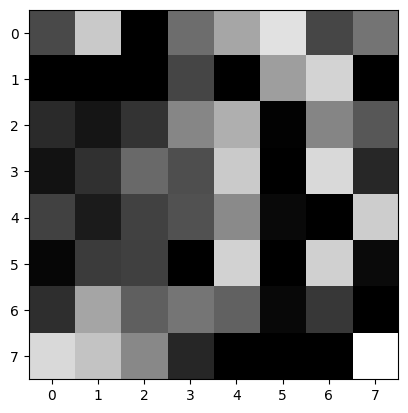

In [435]:
true_data = np.zeros(shape = (8,8))
true_data[0][0] = 1
print(qml.math.fidelity(decoder(diffusion_generation[0][0][0], params_t[0]), torch.from_numpy(true_data)))
# plt.imshow(diffusion_loader[0][0].view(28,28))
# print(params_t)
# params_t.view(28,28).detach()

plt.imshow(torch.relu(params_t).view(8,8).detach(), cmap='gray')


In [273]:
class Layer(qml.operation.Operation):
    
    num_wires = qml.operation.AnyWires
    par_domain = 'R'
    grad_method = 'A'
    # control_wires = [4,5]
    def __init__(self, thetas, wires, id= None):
        # print(thetas)
        print(qml.wires.Wires(wires))
        super().__init__(thetas[0], thetas[1], thetas[2], thetas[3], wires = qml.wires.Wires(wires), id = id)

    
    @property
    def num_params(self):
        return 4
    

    @staticmethod
    def compute_decomposition(thetas, wires):
        return [qml.RX(thetas[0], wires[0]),
        qml.RZ(thetas[1], wires[1]),
        qml.RX(thetas[2], wires[2]),
        qml.CNOT(wires[:2]),
        qml.MultiRZ(thetas[3], [wires[0], wires[1], wires[2]]),
        qml.CNOT([wires[1], wires[2]]),
        qml.CY([wires[0],wires[2]])]

In [340]:
@qml.qnode(gan_dev, diff_method = 'parameter-shift')
def gan_circuit(input, params):
    const = 4
    state = np.sqrt(np.absolute(np.diagonal(input)))
    # print(np.linalg.norm(state))
    qml.QubitStateVector(state, wires = [0,1,2])
    for i in range(3):
        # Parameterised layer
        Layer.compute_decomposition(thetas = params[const*i:const*(i+1)], wires = [0,1,2])
        qml.Barrier()
     #measurement layer
    measurements = []
    for j in range(num_qubits):
        qml.CNOT(wires = [j, 3])
        if j>0:
            qml.cond(measurements[j-1], qml.RY)(params[const*q_depth+j], wires = 3)
        else:
            qml.RY(params[const*q_depth+j], wires = 3)
        qml.CNOT(wires = [3, (j+1)%num_qubits])
        measurements.append(qml.measure(wires = 3, reset = True))
    qml.CNOT(wires = [0,3])
    qml.CNOT(wires = [1,3])
    qml.cond(measurements[2], qml.RY)(params[const*q_depth+num_qubits], wires = 3)
    qml.CNOT(wires = [3,1])
    measurements.append(qml.measure(wires = 3, reset = True))
    qml.CNOT(wires = [1,3])
    qml.CNOT(wires = [2,3])
    qml.cond(measurements[3], qml.RY)(params[const*q_depth+num_qubits+1], wires = 3)
    measurements.append(qml.measure(wires = 3, reset = True))

    return [qml.probs(op = measurements[i]) for i in range(len(measurements))]

def quantum_process(noise, params):
    probs = None
    probs = gan_circuit(noise, params)
    probs_tens = torch.Tensor()
    probs_tens.requires_grad = True
    probs_tens = torch.cat((probs_tens, torch.eye(1)))
    for i in range(len(probs)):
        probs_tens = torch.kron(probs_tens, probs[i])
    probs_tens = torch.div(probs_tens.clone(), torch.sum(probs_tens.clone()))
    probs_tens = torch.div(probs_tens.clone(), torch.max(probs_tens.clone()))
    # tens.requires_grad = True
    return probs_tens


In [398]:
class PatchGenerator(nn.Module):
    def __init__(self, q_delta = 1, n_generators = 16):
        super().__init__()
        self.n_generators = n_generators
        self.q_depth = 3
        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand((self.q_depth * 4 + 5)), requires_grad=True)
                for _ in range(self.n_generators)
            ]
        )
        self.expand = nn.Sequential(
            nn.ConvTranspose2d(32,1,25,1, bias = False),
            # nn.LeakyReLU(),
            # nn.ConvTranspose2d(32,1,16,2),
            nn.Sigmoid()
        )
    def forward(self, x):
        patch_size = 32
        images = torch.Tensor(x.size(0), 0).to(device)
        # print(x.size(0))
        index = [0]*x.size(0)
        for params in self.q_params:
            patches = torch.Tensor(0, patch_size).to(device)
            for i in range(x.size(0)):
                # print(elem)
                # print(x[i][index[i]])
                quantum_probs = quantum_process(x[i][index[i]], params)
                # print(quantum_probs.shape)
                patches = torch.cat((patches, quantum_probs.float()))
                index[i] += 1
            # print(patches.shape)
            images = torch.cat((images, patches), 1)
            # print(images.shape)
        images = images.view(x.size(0),32,4,4)
        images = self.expand(images)
        # print(images.shape)
        images = images.view(x.size(0),-1,28*28)
        # print(images.shape)
        return images


In [393]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""
    #class conditional GAN
    def __init__(self):
        super().__init__()
    
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [399]:
lrG = 0.08 # Learning rate for the generator
lrD = 0.007 # Learning rate for the discriminator
num_iter = 120  # Number of training iterations

In [400]:
train_loader = torch.utils.data.DataLoader(
    new_loader, batch_size=1, shuffle=True
)

In [401]:
discriminator = Discriminator().to(device)
generator = PatchGenerator().to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
random_states = torch.zeros((8,16,8,8)).cfloat()
for i in range(8):
    for j in range(16):
        fixed_noise = np.random.normal(size=(2**num_qubits,)) + 1j*np.random.normal(size=(2**num_qubits,))
        fixed_noise = fixed_noise / np.linalg.norm(fixed_noise) 
        fixed_noise = np.outer(fixed_noise, np.conj(fixed_noise).T)
        random_states[i][j] = torch.from_numpy(fixed_noise).cfloat()
# print(random_states.shape)
# print(fixed_noise)

# Iteration counter

# Collect images for plotting later
results = []
# inputs_T = diffused_states[-1]
# param = torch.tensor(params_tot[-1])
# input_tplus1 = model.prepareInput_t(inputs_T, 0, param)
for epoch in range(1):
    counter = 0
    for i, (data, _) in enumerate(new_loader):

        # Data for training the discriminator
        # print(data.shape)
        data = data.reshape(-1, 28*28)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        # noise = torch.rand(1, 12, device=device) * math.pi 
        fake_data = generator(torch.Tensor(diffusion_generation[0][i]).unsqueeze(0))

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)
        # print(outD_fake.shape)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1
    
        # Show loss values
        if counter % 20 == 0:
            print(f'Epoch: {epoch+1}, Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            # print(generator(fixed_noise)..shape())
            # print(test_images.sh/ape)

            # Save images every 50 iterations
        if counter % 50 == 0:
            test_images = generator(random_states).view(8,1,28,28).cpu().detach()
            results.append(test_images)


Epoch: 1, Iteration: 20, Discriminator Loss: 1.276, Generator Loss: 0.853
Epoch: 1, Iteration: 40, Discriminator Loss: 1.233, Generator Loss: 0.872
Epoch: 1, Iteration: 60, Discriminator Loss: 1.235, Generator Loss: 0.856
Epoch: 1, Iteration: 80, Discriminator Loss: 1.248, Generator Loss: 0.833
Epoch: 1, Iteration: 100, Discriminator Loss: 1.251, Generator Loss: 0.804
Epoch: 1, Iteration: 120, Discriminator Loss: 1.310, Generator Loss: 0.805
Epoch: 1, Iteration: 140, Discriminator Loss: 1.325, Generator Loss: 0.760
Epoch: 1, Iteration: 160, Discriminator Loss: 1.293, Generator Loss: 0.800
Epoch: 1, Iteration: 180, Discriminator Loss: 1.405, Generator Loss: 0.740
Epoch: 1, Iteration: 200, Discriminator Loss: 1.381, Generator Loss: 0.702
Epoch: 1, Iteration: 220, Discriminator Loss: 1.297, Generator Loss: 0.699
Epoch: 1, Iteration: 240, Discriminator Loss: 1.180, Generator Loss: 0.773
Epoch: 1, Iteration: 260, Discriminator Loss: 1.301, Generator Loss: 0.723
Epoch: 1, Iteration: 280, Dis

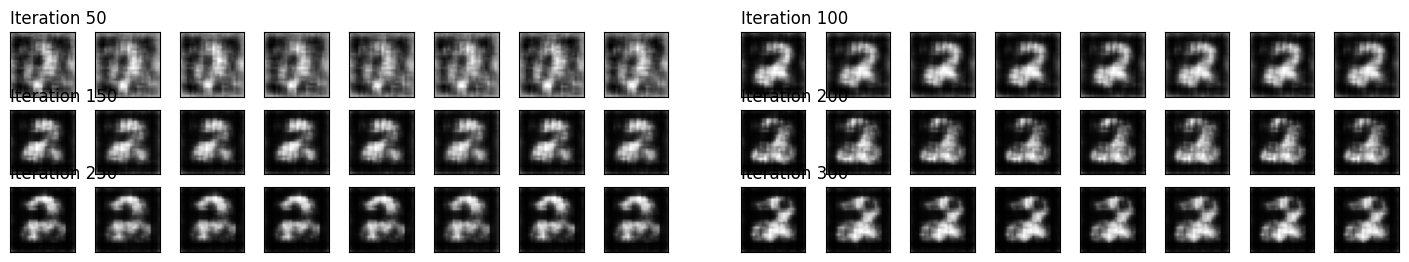

In [402]:
fig = plt.figure(figsize=(18, 18))
outer = gridspec.GridSpec(18, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()

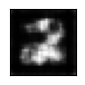

In [403]:
random_states = torch.zeros((1,16,8,8)).cfloat()
for j in range(16):
    fixed_noise = np.random.normal(size=(2**num_qubits,)) + 1j*np.random.normal(size=(2**num_qubits,))
    fixed_noise = fixed_noise / np.linalg.norm(fixed_noise) 
    fixed_noise = np.outer(fixed_noise, np.conj(fixed_noise).T)
    random_states[0][j] = torch.from_numpy(fixed_noise).cfloat()
test_images = generator(random_states).view(1,1,28,28).cpu().detach()
fig = plt.figure(figsize=(10, 6))
outer = gridspec.GridSpec(6, 2, wspace=0.1)
inner = gridspec.GridSpecFromSubplotSpec(1, test_images.size(0),
                    subplot_spec=outer[i])
images = torch.squeeze(test_images, dim=1)
for j, im in enumerate(images):

    ax = plt.Subplot(fig, inner[j])
    ax.imshow(im.numpy(), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    # if j==0:
        # ax.set_title(f'Iteration {50+i*50}', loc='left')
    fig.add_subplot(ax)
    
plt.show()